In [1]:
import matplotlib.pyplot as plt
import numpy as np
import mpmath as mp
mp.mp.dps = 30 #higher precision
import csv
import json
from PyMatching import *
import pickle

In [2]:
#pymatching to compare to
num_shots = 100000
Ls = [4,6]
ps = np.linspace(0.01, 0.12, 12)
np.random.seed(2)
log_errors_all_L = []
for L in Ls:
    print("Simulating L={}...".format(L))
    Hx = toric_code_x_stabilisers(L)
    logX = toric_code_x_logicals(L)
    log_errors = []
    for error_probability in ps:
        num_errors = num_decoding_failures_vectorised(Hx, logX, error_probability, num_shots)
        log_errors.append(num_errors/num_shots)
    log_errors_all_L.append(np.array(log_errors))

Simulating L=4...
Simulating L=6...


In [3]:
#Log sum exp with arbitrary precision governed by mp
#In particular this gives infinite temperature version of the free energy, for scaling
def log_sum_exp(to_sum):
    maxval = max(to_sum)
    exp_sum = 0
    for value in to_sum:
        exp_sum += mp.exp(value-maxval)
    res = maxval + mp.log(exp_sum)
    return res

#Free energy given histogram and temperature, arbitrary precision governed by mp
def free_energy(E_list, log_g_list,  T):
    to_sum = []
    for i, log_g in enumerate(log_g_list):
        to_sum.append(log_g - E_list[i]/T)
    maxval = max(to_sum)
    exp_sum = 0
    for value in to_sum:
        exp_sum += mp.exp(value-maxval)
    res = maxval + mp.log(exp_sum)
    return -T*res

#Run over batch of results, structured by seed, then by class
def get_free_energies(rescaled_results,temperatures):
    free_energies = []
    for seed_results in rescaled_results:
        free_energy_classes = []
        for error_result in seed_results:
            f_values = []
            for T in temperatures:
                f_values.append(free_energy(error_result[0], error_result[1], T)/(-T))
            free_energy_classes.append(f_values)
        free_energies.append(free_energy_classes)
    return free_energies

#For comparisons to MWPM algorithms
def get_lowest_energies(rescaled_results):
    lowest_energies = []
    for seed_results in rescaled_results:
        lowest_energy_classes = []
        for error_result in seed_results:
            e_values = min(error_result[0])
            lowest_energy_classes.append(e_values)
        lowest_energies.append(lowest_energy_classes)
    return lowest_energies

#For comparisons to MWPM algorithms
def get_lowest_g(rescaled_results):
    lowest_g = []
    for seed_results in rescaled_results:
        lowest_g_classes = []
        for error_result in seed_results:
            g_values = min(error_result[1])
            lowest_g_classes.append(g_values)
        lowest_g.append(lowest_g_classes)
    return lowest_g

Here starts the processing of data inside json like txt files 

In [4]:
import re

def read_results_file(path):

    with open(path, 'r') as file:
        content = file.read()

    content = content.strip().rstrip(',')

    corrected_json = f'[{content}]'

    try:
        data = json.loads(corrected_json)
    except json.JSONDecodeError as e:
        print(f"Failed to parse JSON: {e}")

    return data

def parse_file(filename):
    data = []
    try:
        with open(filename, 'r') as file:
            content = file.read()
            # print("file content printout (for debugging):")
            # print(content)
    except FileNotFoundError:
        return

    # Split content into individual blocks
    blocks = content.split('}\n{')  # Assuming blocks are separated by double newlines

    for block in blocks:
        # Extract histogram_seed, run_seed, and results
        histogram_seed_match = re.search(r'"histogram_seed": "(\d+)"', block)
        run_seed_match = re.search(r'"run_seed": "(\d+)"', block)
        results_match = re.search(r'"results": \[([^]]*)\]', block)

        if histogram_seed_match and run_seed_match and results_match:
            histogram_seed = histogram_seed_match.group(1)
            run_seed = run_seed_match.group(1)
            results_str = results_match.group(1)

            # Process results
            results = {}
            results_items = results_str.split(',')
            for item in results_items:
                key_value = item.split(':')
                if len(key_value) == 2:
                    key = key_value[0].strip().strip('"')
                    value = float(key_value[1].strip())
                    results[key] = value

            data.append({
                "histogram_seed": histogram_seed,
                "run_seed": run_seed,
                "results": results
            })

    return data

def process_data(data, batch_results, p, size, error):
    for entry in data:
        histogram_seed = entry["histogram_seed"]
        run_seed = entry["run_seed"]
        results = entry["results"]

        E_list = []
        log_g_list = []

        # Process the results
        for key, value in results.items():
            E_list.append(int(key))
            log_g_list.append(float(value))

        batch_results.append({
                'prob': p,
                'size': size,
                'error': error,
                'histogram_seed': histogram_seed,
                'run_seed': run_seed,
                'E': E_list,
                'log_g': log_g_list
            })
        # offset = log_sum_exp(log_g_list)
        # print('deviation from sqrt(2)xy: ', mp.log(2)*size*size - offset, ' log sum exp:', offset)

In [5]:
boundary_type = "periodic"
batch_results = []
probabilities = [0.1, 0.11, 0.12]
sizes = [4, 6]
intervals = 10
iterations = 1000
overlap = 0.25
walkers = 8
alpha = 0.8
beta = 1e-7
exchange = 50

batch_results = []

for p in probabilities:
    for size in sizes:
        for error in ["I", "X", "Y", "Z"]:
            filename = f"../results/periodic/prob_{p:.6f}/X_{size}_Y_{size}/error_class_{error}/StitchedHistogram_intervals_{intervals}_iterations_{iterations}_overlap_{overlap:.6f}_walkers_{walkers}_alpha_{alpha:.6f}_beta_{beta:.10f}_exchange_offset{exchange}.txt"
            data = read_results_file(filename)

            if data:
                process_data(data, batch_results, p, size, error)
print(len(batch_results))

24000


In [6]:
from collections import defaultdict

# only keep results which come with all different error types:
#Changing structure to match postprocessing and plotting

# grouped dictionary with keys prob size and hist seed
grouped_results = defaultdict(list)
for result in batch_results:
    key = (result['prob'], result['size'], result['histogram_seed'])
    grouped_results[key].append(result)

In [7]:
filtered_results = defaultdict(list)
for key, results in grouped_results.items():
    newkey = (key[0],key[1])
    errors = set(result['error'] for result in results)
    if errors == {'I', 'X', 'Y', 'Z'}:
        # To be removed once normalization is properly handled in c
        for result in results:
            log_g_list = result['log_g']
            offset = log_sum_exp(log_g_list)
            rescaled_log_g_list = [res + mp.log(2)*key[1]*key[1] - offset for res in log_g_list]
            result['log_g'] = rescaled_log_g_list
        filtered_results[newkey].append([[result['E'], result['log_g']] for result in results])
    else:
        print(f"has issue with an error class prob: {key[0]} size: {key[1]} interaction seed: {key[2]} available errors: {errors}")

In [8]:
# Save to a pickle file
with open('filtered_results_without.pkl', 'wb') as f:
    pickle.dump(filtered_results, f)

In [9]:
free_energies_batch = []
for p in probabilities:
    T_Nish = 1/(mp.log((1-p)/p)/2)
    temperatures = [1e-20,T_Nish,1e20]
    free_energies_size = []
    for size in sizes:
        batch_res = filtered_results[(p,size)]
        free_energies = get_free_energies(batch_res,temperatures)
        free_energies_size.append(free_energies)
        print('Number of seeds at p',p,', size',size,':', len(free_energies))
    free_energies_batch.append(free_energies_size)

Number of seeds at p 0.1 , size 4 : 1000
Number of seeds at p 0.1 , size 6 : 1000
Number of seeds at p 0.11 , size 4 : 1000
Number of seeds at p 0.11 , size 6 : 1000
Number of seeds at p 0.12 , size 4 : 1000
Number of seeds at p 0.12 , size 6 : 1000


In [10]:
with open('free_energies_batch_without.pkl', 'wb') as f:
    pickle.dump(free_energies_batch, f)

In [11]:
optimal_curves = []
T0_curves = []
for i, p in enumerate(probabilities):
    optimal_curve = []
    T0_curve = []
    for j in range(len(sizes)):

        free_energies = free_energies_batch[i][j]

        #TO CHECK: if there is ever any significant difference between <= and < here
        #if so, should take degeneracy into account, and count with fraction if <=
        #Seems not to be an issue though

        temp = 1 #Nishimori temp
        res =  1 - mp.fsum([f_class[0][temp] < f_class[1][temp]\
               or f_class[0][temp] < f_class[2][temp]\
               or f_class[0][temp] < f_class[3][temp] for f_class in free_energies])/(len(free_energies))
        optimal_curve.append(res)

        temp = 0 #Low temp
        res =  1 - mp.fsum([f_class[0][temp] < f_class[1][temp]\
               or f_class[0][temp] < f_class[2][temp]\
               or f_class[0][temp] < f_class[3][temp] for f_class in free_energies])/(len(free_energies))
        T0_curve.append(res)

    optimal_curves.append(optimal_curve)
    T0_curves.append(T0_curve)

In [12]:
with open('optimal_curves_without.pkl', 'wb') as f:
    pickle.dump(optimal_curves, f)

with open('T0_curves_without.pkl', 'wb') as f:
    pickle.dump(T0_curves, f)

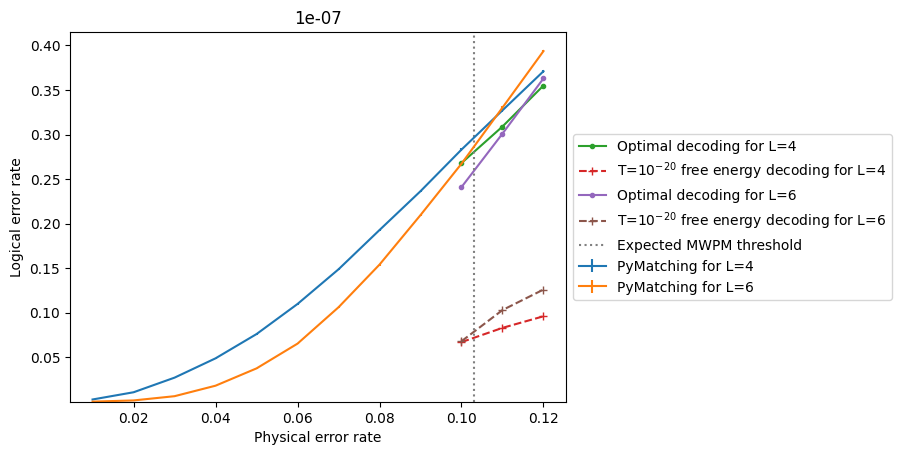

In [15]:
plt.figure()
for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    plt.errorbar(ps, logical_errors, yerr=std_err, label="PyMatching for L={}".format(L))


for i, size in enumerate(sizes):
    plt.plot(probabilities, [1-optimal_curves[j][i] for j in range(len(probabilities))],".-",label=r"Optimal decoding for L=%d"%size)
    plt.plot(probabilities, [1-T0_curves[j][i] for j in range(len(probabilities))],"+--",label=r"T=$10^{-20}$ free energy decoding for L=%d"%size)

plt.axvline(x=0.1031,color="gray",label="Expected MWPM threshold",linestyle="dotted")

plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")

#plt.xscale('log')
#plt.yscale('log')
plt.ylim(bottom=1e-4, top=None)
plt.title(beta)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()